In [14]:
import glob, os
import numpy as np
import impedance
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M")
### Importnt Note: Enter the path using '/' instead of '\' #####

path = 'C:/Users/Shivam Chopra/OneDrive - Indian Institute of Science/Documents/Glove_Box_Inductance/20210130_1_Outside_Glove_Box/'
filename = dt_string + '_20210130_1_Outside_Glove_Box'

# Import all files in the folder ending with .z
all_files = []
file_names = []
for file in glob.glob(path + str('*.z')):
    all_files.append(file)

# Extract file names from all_files
# all_files is a nested list
import itertools
full_file_name = list(itertools.chain(all_files))

# Split full file name (with address) into just file name 
for y in range(len(all_files)):
    file_names.append(full_file_name[y].split('\\')[1])
        
print(np.shape(all_files), np.shape(full_file_name), np.shape(file_names), dt_string)

(4,) (4,) (4,) 20210225_1317


In [15]:
from impedance.preprocessing import cropFrequencies, ignoreBelowX
freqs = []
Zs = []
# Now loop through file names in our list and extract data one by one
for x in range(len(all_files)):
    # Skipping rows to remove any trivial information
    c = np.loadtxt(all_files[x], delimiter = '\t', skiprows = 144)
    freq = c[:,0]  # 1st column of data is frequencies
    Z = c[:,4] + 1j*c[:,5]  # 5th column is real, 6th column is imaginary  
    Zs.append(Z)
    freqs.append(freq)
        
# Check to see if we extracted data for all the files
print(np.shape(freqs),np.shape(Zs))

(4, 61) (4, 61)


In [16]:
# Lin KK Calculation
from impedance.validation import linKK
Zs_linKK = []

for y in range (len(all_files)):
    M, mu, Z_linKK, res_real, res_imag = linKK(freqs[y], Zs[y], c=.5, max_M=100, fit_type='complex', add_cap=True)
    Zs_linKK.append(Z_linKK)

10 0.6597856206123868 265747.7651157751


C:\ProgramData\Anaconda3\lib\site-packages\impedance\validation.py:292: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - neg_sum/pos_sum


In [17]:
from impedance.models.circuits import CustomCircuit, fitting

circuits = []
parameters = []
#constants = {'R0':1075}
constants = {}

circ_string = 'L1-p(R1,C1)' #Circuit combination in string
circ_variables = 'Inductance(H) Resistance(Ohm) Capacitance(F) RMSE'
perm_initial_guess = [10, 1E6, 1E-3]  
bounds = [[1E-6, 100, 1E-6], perm_initial_guess] 

initial_guess = perm_initial_guess # 1st guess for flag = 1 case
# function for fitting data
def fit_circuit (f, Z, circ_string, initial_guess, name, circuits, parameters):
    for x in range(100):   # defining custom circuit
        circuit = CustomCircuit(circ_string, initial_guess=initial_guess, name=name, constants=constants)
        circuit.fit(f, Z, bounds = bounds)     # fiiting in custom circuit
        initial_guess = circuit.parameters_    # previous initial guess for next iteration
    circuits.append(circuit)     # appending circuits  
    parameters.append(circuit.parameters_)
    
# Now loop through data list to create circuits and fit them
for x in range(len(all_files)):
    initial_guess = perm_initial_guess
    fit_circuit (freqs[x], Zs_linKK[x], circ_string, initial_guess, file_names[x], circuits, parameters)
                
print (np.shape(circuits), np.shape(parameters))

(4,) (4, 3)


In [18]:
fits = []
potential = []      # to append bias column in parameters
rmse = []      # to append rmse error in parameters

for y, circuit in zip(range(len(all_files)), circuits):
    fit = circuit.predict(freqs[y])
    fits.append(fit)
    rmse.append(fitting.rmse(Zs_linKK[y], fit))    
    print(circuit)
    
rmse_col = np.array(rmse)

#append all column in parameters
output_pars = np.c_[parameters, rmse_col]                
np.savetxt(filename + '_Fit_Paramters.txt', output_pars, header=circ_variables, comments=circ_string + str(constants))
print(np.shape(fits), np.shape(output_pars)) 


Name: 20210130_1_100_Ohm_EIS_Run01_Un1Ch2_Step1.z
Circuit string: L1-p(R1,C1)
Fit: True

Initial guesses:
     L1 = 1.84e-05 [H]
     R1 = 1.00e+02 [Ohm]
     C1 = 1.00e-06 [F]

Fit parameters:
     L1 = 1.84e-05  (+/- 3.81e-05) [H]
     R1 = 1.00e+02  (+/- 6.18e+00) [Ohm]
     C1 = 1.00e-06  (+/- 2.69e-07) [F]


Name: 20210130_1_10K_Ohm_EIS_Run01_Un1Ch2_Step1.z
Circuit string: L1-p(R1,C1)
Fit: True

Initial guesses:
     L1 = 8.16e-04 [H]
     R1 = 8.92e+03 [Ohm]
     C1 = 1.00e-06 [F]

Fit parameters:
     L1 = 8.16e-04  (+/- 5.45e-03) [H]
     R1 = 8.92e+03  (+/- 1.24e+03) [Ohm]
     C1 = 1.00e-06  (+/- 4.33e-07) [F]


Name: 20210130_1_1K_Ohm_EIS_Run01_Un1Ch2_Step1.z
Circuit string: L1-p(R1,C1)
Fit: True

Initial guesses:
     L1 = 4.35e-05 [H]
     R1 = 9.33e+02 [Ohm]
     C1 = 1.00e-06 [F]

Fit parameters:
     L1 = 4.35e-05  (+/- 4.74e-04) [H]
     R1 = 9.33e+02  (+/- 8.86e+01) [Ohm]
     C1 = 1.00e-06  (+/- 3.59e-07) [F]


Name: 20210130_1_1M_Ohm_EIS_Run01_Un1Ch2_Step1.z
Circui

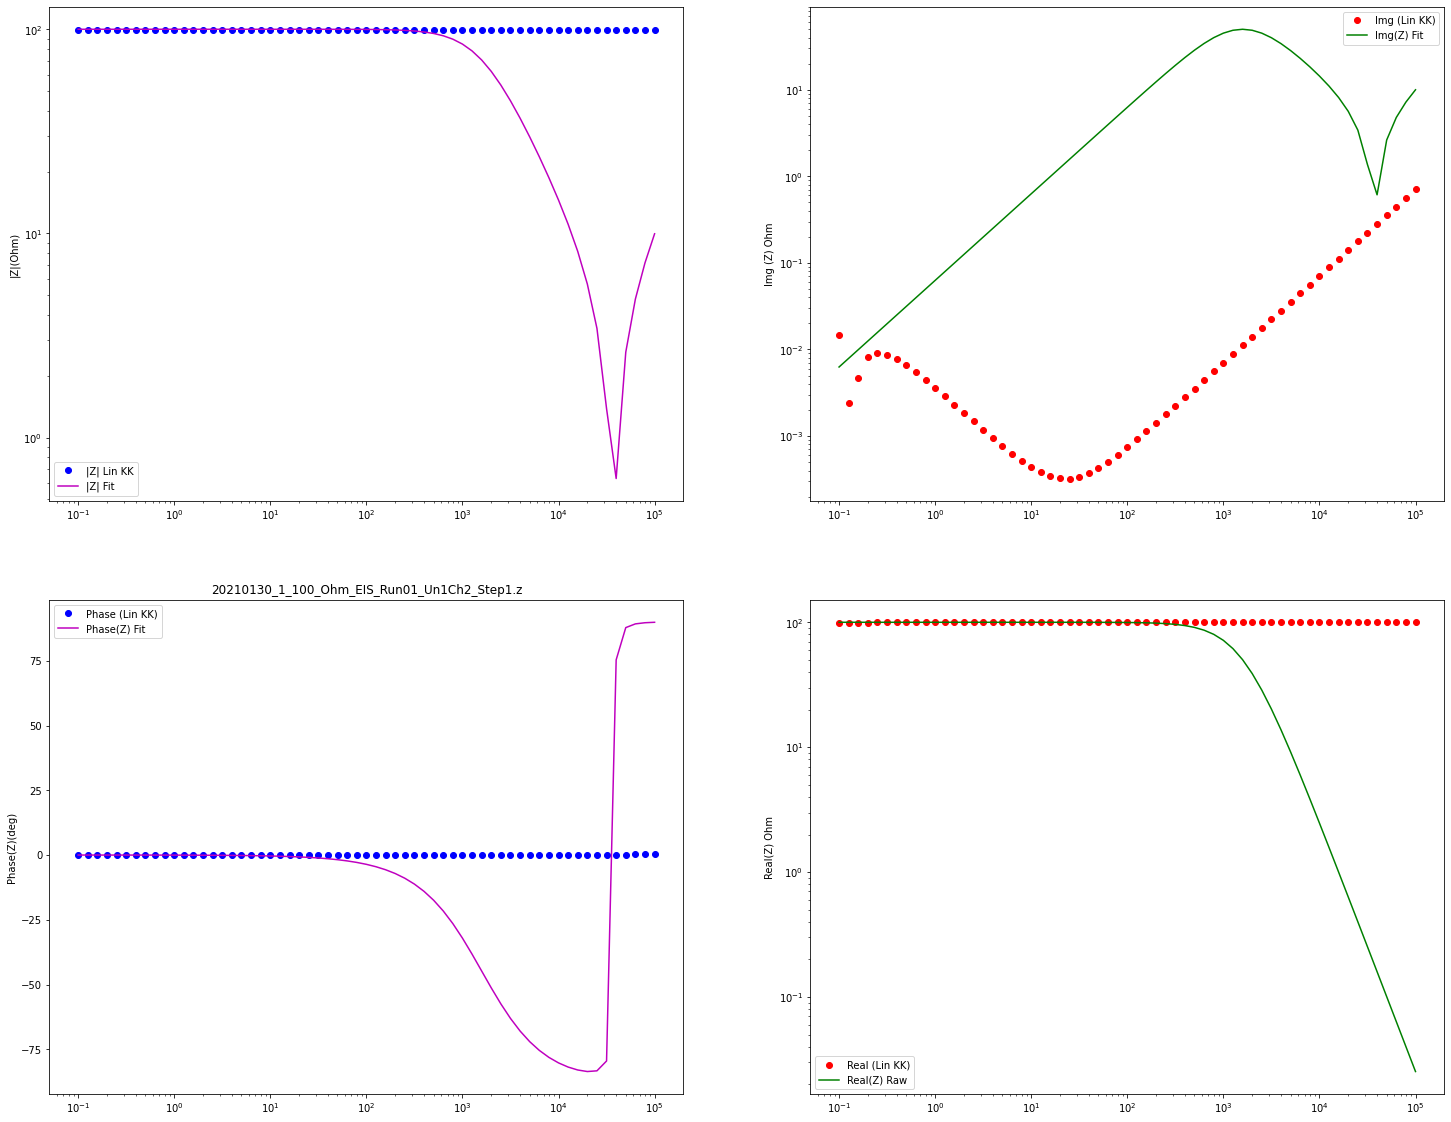

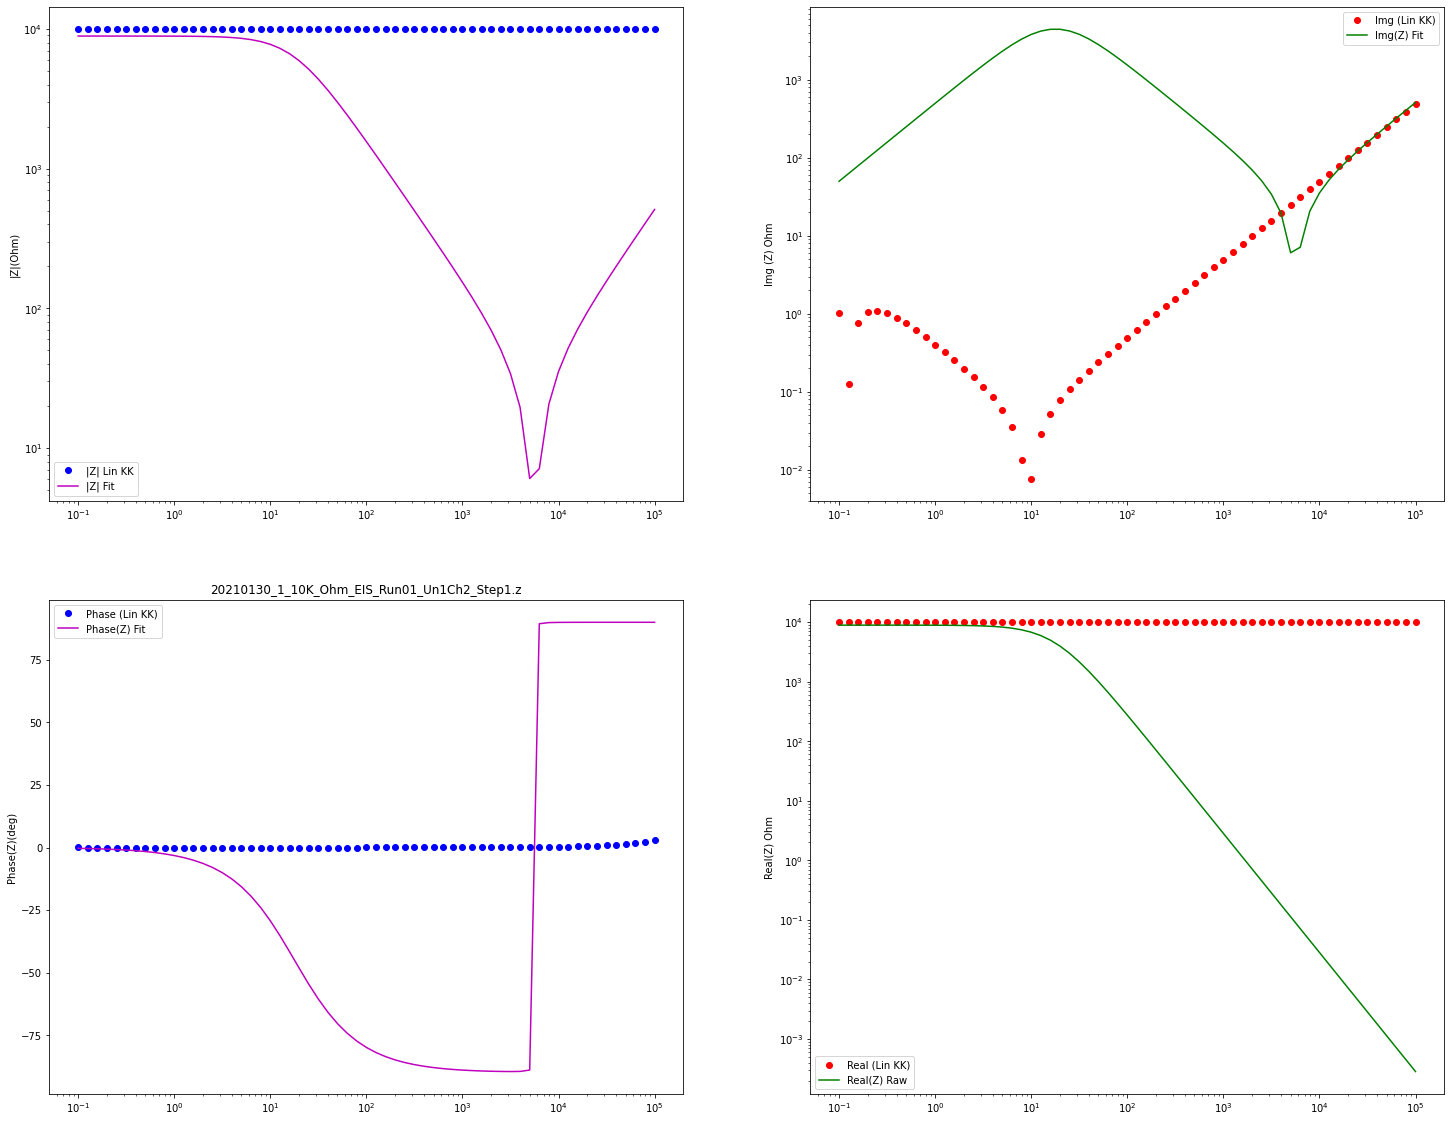

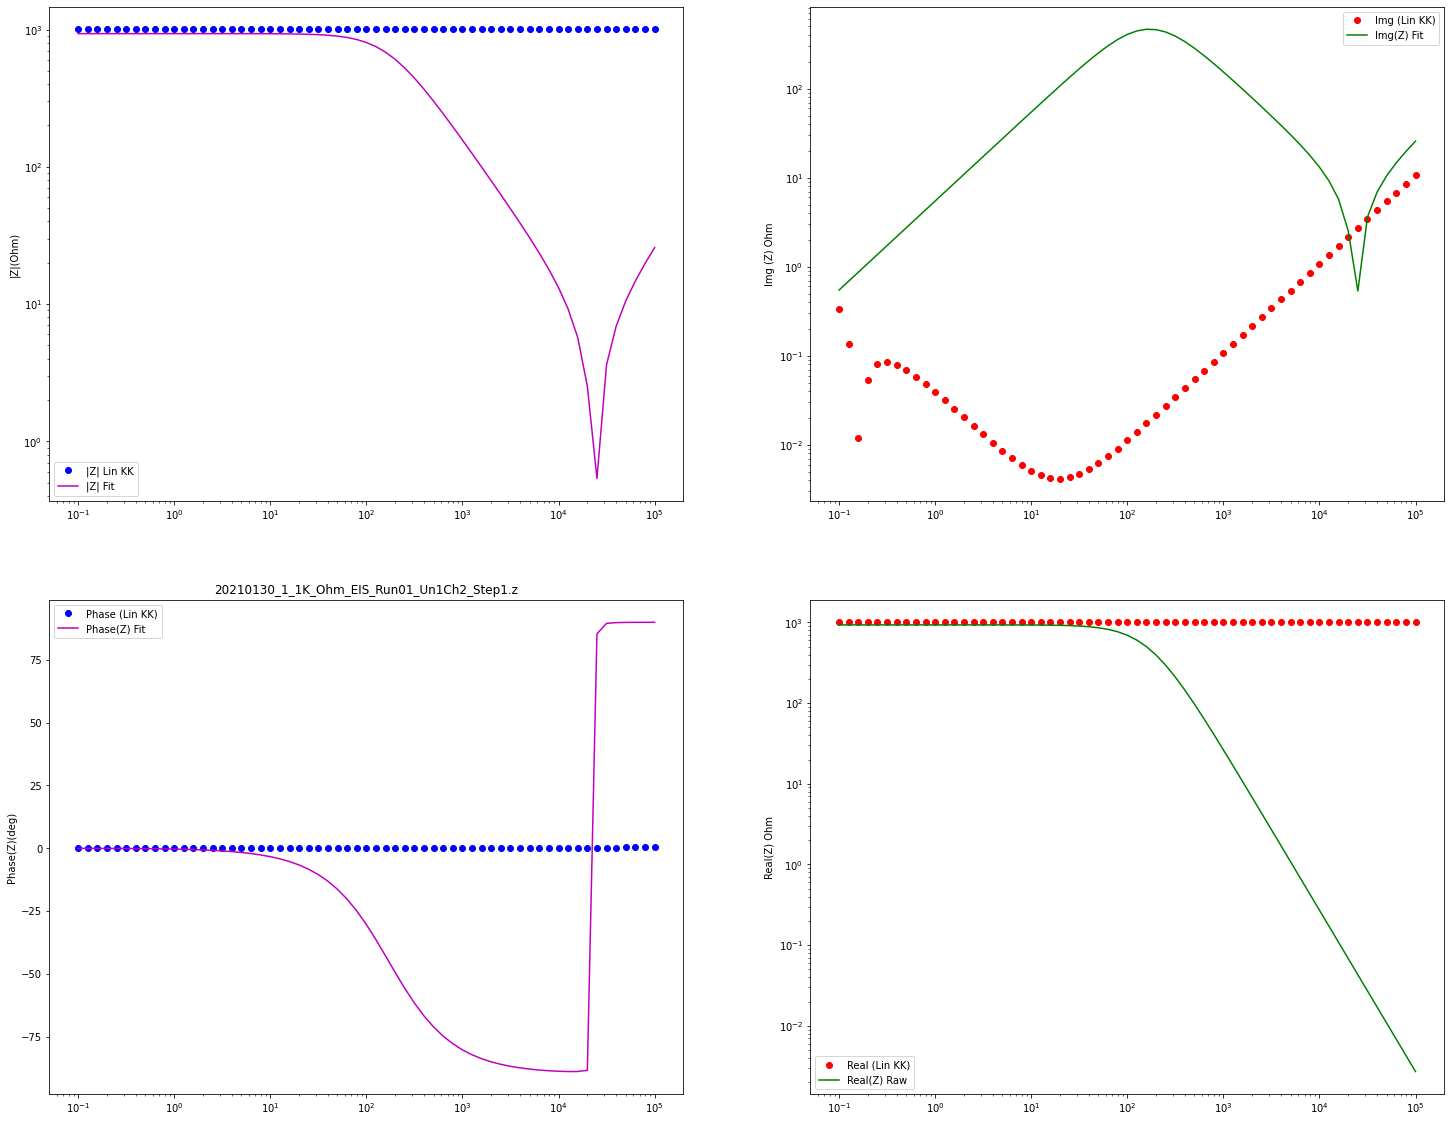

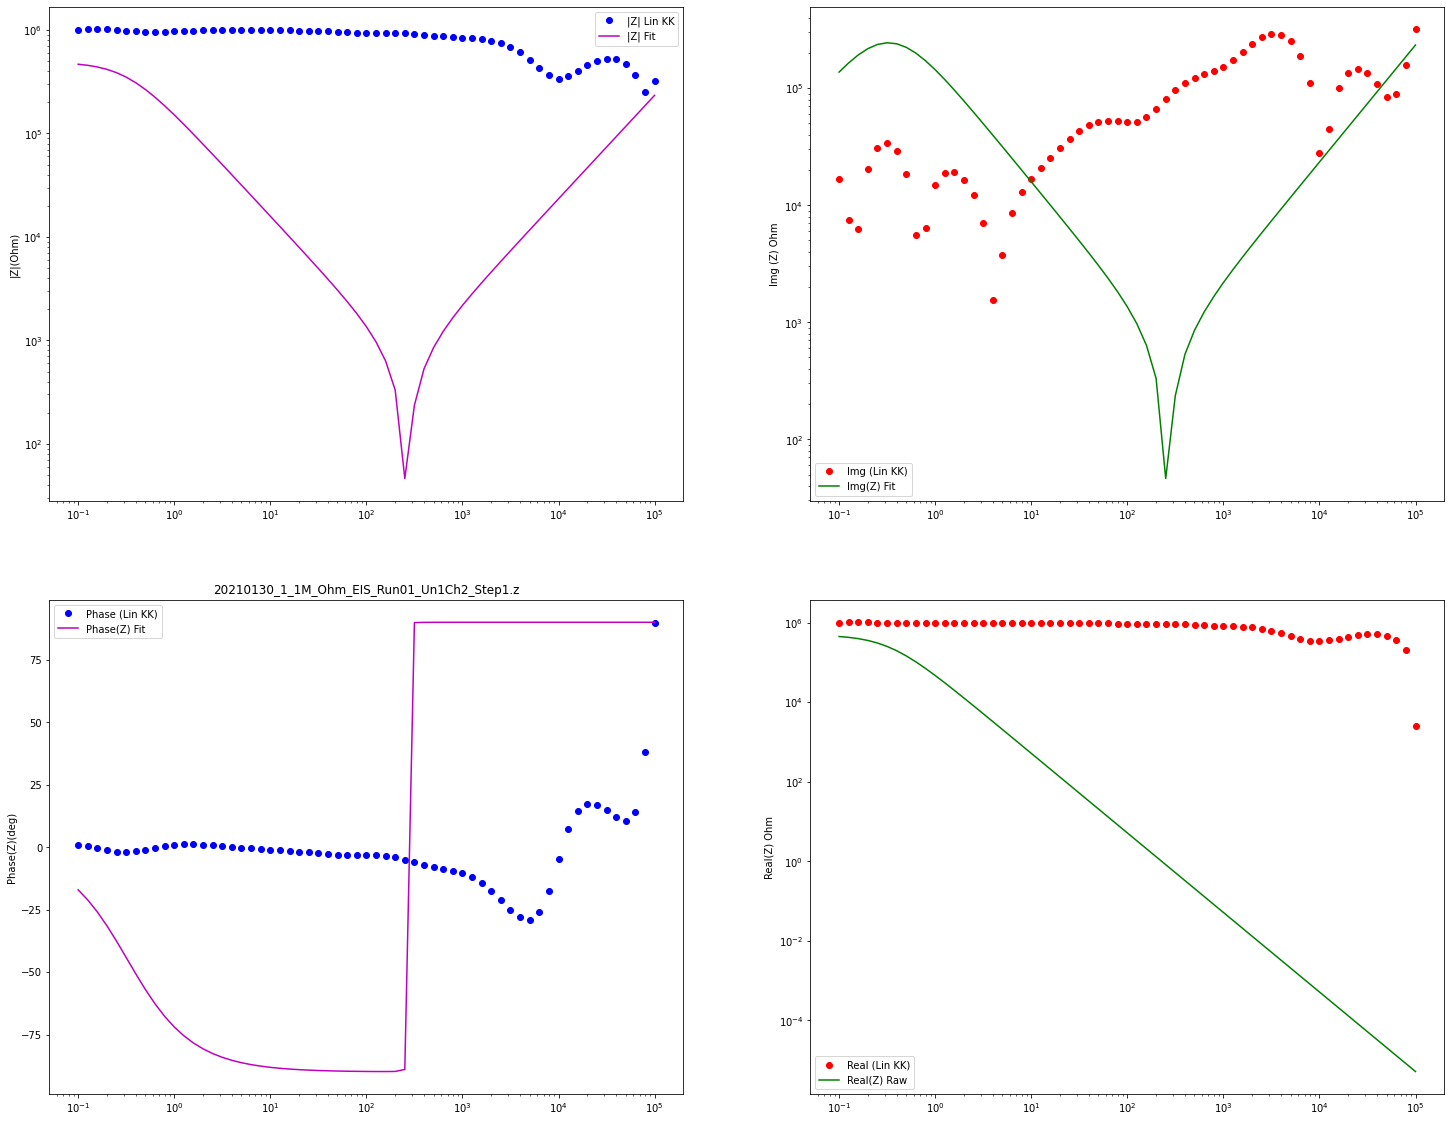

In [19]:
import matplotlib.pyplot as plt
import cmath
# Initialize .pdf file for saving graphs
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(filename + '_Fit_Graphs.pdf')
# Don't show warning if no. of pics are more
plt.rcParams.update({'figure.max_open_warning': 0})

#for y, fit in zip(range(len(all_files)), fits):     
#    figure, ax = plt.subplots(figsize=(15,15))
#    plt.title(file_names[y])
#    ax.set_xlabel('real(Z) (Ohm)')
#    ax.set_ylabel('img(Z) (Ohm)')
#    ax.plot(np.abs(Zs[y].real), np.abs(Zs[y].imag), 'ob', label = 'Raw')
#    ax.plot(np.abs(fit.real), np.abs(fit.imag), '-m', label = 'Fit')
#    plt.axis('scaled')
#    ax.legend()
#    pdf.savefig(figure)

for y, fit in zip(range(len(all_files)), fits):     
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(25,20))
    axes[1][0].set_title(file_names[y])
    axes[0][0].set_xscale('log')
    axes[1][0].set_xscale('log')
    axes[0][1].set_xscale('log')
    axes[1][1].set_xscale('log')
    axes[0][0].set_yscale('log')
    axes[0][1].set_yscale('log')
    axes[1][1].set_yscale('log')
    axes[0][0].set_ylabel('|Z|(Ohm)')
    axes[0][1].set_ylabel('Img (Z) Ohm')
    axes[1][0].set_ylabel('Phase(Z)(deg)')
    axes[1][1].set_ylabel('Real(Z) Ohm')
    
    axes[0][0].plot(freqs[y], np.abs(Zs_linKK[y]), 'ob', label = '|Z| Lin KK')
    axes[0][0].plot(freqs[y], np.abs(fit), '-m', label = '|Z| Fit')
    axes[0][1].plot(freqs[y], np.abs(Zs_linKK[y].imag), 'or', label = 'Img (Lin KK)')
    axes[0][1].plot(freqs[y], np.abs(fit.imag), '-g', label = 'Img(Z) Fit')
    axes[1][0].plot(freqs[y], np.angle(Zs_linKK[y], deg=True), 'ob', label = 'Phase (Lin KK)')
    axes[1][0].plot(freqs[y], np.angle(fit, deg=True), '-m', label = 'Phase(Z) Fit')
    axes[1][1].plot(freqs[y], np.abs(Zs_linKK[y].real), 'or', label = 'Real (Lin KK)')
    axes[1][1].plot(freqs[y], np.abs(fit.real), '-g', label = 'Real(Z) Raw')
    
    axes[0][0].legend()
    axes[0][1].legend()
    axes[1][0].legend()
    axes[1][1].legend()
    
    pdf.savefig(fig)
    
pdf.close()    

In [56]:
#Export Data
for y in range(len(all_files)):
    my_header = 'Freq/Hz Z(a)/Ohm Z(b)/Ohm Z/Ohm Phase/deg'
    phase = -1*(np.angle(Zs_linKK[y], deg=True))
    mag = np.abs(Zs_linKK[y])
    output_data = np.c_[freqs[y], Zs_linKK[y].real, -1*Zs_linKK[y].imag, mag, phase]
    np.savetxt(file_names[y] + '_Raw.txt', output_data, header=my_header, comments=str({}))